#  금융 ETF 추천 시스템 구축

> 목표 : `Text2SQL` 기반 RAG 체인 정확도 개선

```mermaid
flowchart LR
    Q[사용자 질문] --> P[프로필 분석]
    P -->|투자 성향 & 목표 추출| S[SQL 쿼리 생성]
    S -->|데이터베이스 조회| E[후보 ETF 검색]
    E -->|필터링 조건 적용| R[랭킹 및 필터링]
    R -->|상위 후보 선정| D[설명 생성]
    
    style Q fill:#e1f5fe,stroke:#01579b
    style P fill:#e8f5e9,stroke:#1b5e20
    style S fill:#fff3e0,stroke:#e65100
    style E fill:#f3e5f5,stroke:#4a148c
    style R fill:#fbe9e7,stroke:#bf360c
    style D fill:#e8eaf6,stroke:#1a237e

    subgraph 데이터 처리
    S
    E
    R
    end

    subgraph 출력 생성
    D
    end
```

---

## 0. 환경 설정

In [1]:
import os
from glob import glob

from pprint import pprint
import json
import ast

import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

True

In [3]:
from langfuse.langchain import CallbackHandler

# Langfuse 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [17]:
import time
import logging
from datetime import datetime
from typing import Dict, List, Any, Optional
from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.outputs import LLMResult

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

class PerformanceMonitoringCallback(BaseCallbackHandler):
    """LLM 호출 성능을 모니터링하는 콜백 핸들러"""
    
    def __init__(self):
        self.start_time: Optional[float] = None
        self.token_usage: Dict[str, Any] = {}
        self.call_count: int = 0
        
    def on_llm_start(
        self, 
        serialized: Dict[str, Any], 
        prompts: List[str], 
        **kwargs: Any
    ) -> None:
        """LLM 호출이 시작될 때 호출"""
        self.start_time = time.time()
        self.call_count += 1
        print(f"🚀 LLM 호출 #{self.call_count} 시작 - {datetime.now().strftime('%H:%M:%S')}")
        
        # 첫 번째 프롬프트의 길이 확인
        if prompts:
            print(f"📝 프롬프트 길이: {len(prompts[0])} 문자")
        
    def on_llm_end(self, response: LLMResult, **kwargs: Any) -> None:
        """LLM 호출이 완료될 때 호출"""
        if self.start_time:
            duration = time.time() - self.start_time
            print(f"✅ LLM 호출 완료 - 소요시간: {duration:.2f}초")
            
            # 토큰 사용량 추적
            if response.generations:
                generation = response.generations[0][0]
                
                # usage_metadata를 우선 확인 
                if hasattr(generation, 'usage_metadata') and generation.usage_metadata:
                    usage = generation.usage_metadata
                    print(f"🔢 토큰 사용량: {usage}")
                    self.token_usage = usage
                    
                # 구버전 호환성을 위한 llm_output 확인
                elif hasattr(response, 'llm_output') and response.llm_output:
                    usage = response.llm_output.get('token_usage', {})
                    if usage:
                        print(f"🔢 토큰 사용량: {usage}")
                        self.token_usage = usage
                        
                # 응답 길이 체크
                if hasattr(generation, 'text'):
                    response_text = generation.text
                    print(f"📊 응답 길이: {len(response_text)} 문자")
        
    def on_llm_error(self, error: Exception, **kwargs: Any) -> None:
        """LLM 호출에서 오류가 발생할 때 호출"""
        print(f"❌ LLM 호출 오류: {str(error)}")
        
    def get_statistics(self) -> Dict[str, Any]:
        """현재까지의 통계 정보를 반환"""
        return {
            "total_calls": self.call_count,
            "last_token_usage": self.token_usage
        }
    
# 콜백 핸들러 생성
performance_handler = PerformanceMonitoringCallback()

---

## 1. ETF 데이터 가공

In [7]:
from langchain_community.utilities import SQLDatabase

# SQLite DB 로드
db = SQLDatabase.from_uri("sqlite:///etf_database.db")
print("DB 종류:",  db.dialect)
tables = db.get_usable_table_names()
print("테이블 목록:", tables)

# 테이블별 컬럼명 확인
for table in tables:
    print(f"\n{table} 스키마:")
    schema = db.run(f"PRAGMA table_info({table})")
    result = db.run(f"SELECT * FROM {table} LIMIT 1")
    for sch, row in zip(ast.literal_eval(schema), ast.literal_eval(result)[0]):
        print(f"{sch} - ex: {row}")

DB 종류: sqlite
테이블 목록: ['ETFs', 'ETFsInfo']

ETFs 스키마:
(0, '종목코드', 'TEXT', 0, None, 1) - ex: 466400
(1, '종목명', 'TEXT', 0, None, 0) - ex: 1Q 25-08 회사채(A+이상)액티브
(2, '상장일', 'TEXT', 0, None, 0) - ex: 2023/09/19
(3, '분류체계', 'TEXT', 0, None, 0) - ex: 채권-회사채-단기
(4, '운용사', 'TEXT', 0, None, 0) - ex: 하나자산운용
(5, '수익률_최근1년', 'REAL', 0, None, 0) - ex: 4.52
(6, '기초지수', 'TEXT', 0, None, 0) - ex: KIS 2025-08만기형 크레딧 A+이상 지수(총수익)
(7, '추적오차', 'REAL', 0, None, 0) - ex: 0.11
(8, '순자산총액', 'REAL', 0, None, 0) - ex: 111916276404.0
(9, '괴리율', 'REAL', 0, None, 0) - ex: 0.03
(10, '변동성', 'TEXT', 0, None, 0) - ex: 매우낮음
(11, '복제방법', 'TEXT', 0, None, 0) - ex: 실물(액티브)
(12, '총보수', 'REAL', 0, None, 0) - ex: 0.1
(13, '과세유형', 'TEXT', 0, None, 0) - ex: 배당소득세(보유기간과세)

ETFsInfo 스키마:
(0, '한글명', 'TEXT', 0, None, 0) - ex: PLUS 국채선물3년
(1, '영문명', 'TEXT', 0, None, 0) - ex: PLUS 3-Year Korea Treasury Bond Futures
(2, '종목코드', 'TEXT', 0, None, 1) - ex: 298340
(3, '상장일', 'TEXT', 0, None, 0) - ex: 2018-06-08
(4, '펀드형태', 'TEXT', 0, None

In [8]:
# 주요 정보 조인 테이블 생성
# 쿼리의 일관성, 복잡도를 개선하기 위해 하나의 테이블로 구성함

# db.run("DROP TABLE ETFS_WITH_INFO;") # 테이블 변경하는 경우

join_query = """
CREATE TABLE ETFS_WITH_INFO AS
SELECT  ETFS.*,
        INFO.영문명,
        INFO.펀드형태,
        INFO.기초지수명,
        INFO.추적배수,
        INFO.지정참가회사,
        INFO.회계기간,
        INFO.과세유형,
        INFO.분배금지급일,
        INFO.기초시장,
        INFO.기본정보,
        INFO.투자유의사항
FROM ETFS
LEFT JOIN ETFSINFO AS INFO
ON ETFS.종목코드 = INFO.종목코드;
"""
db.run(join_query)

''

In [28]:
db = SQLDatabase.from_uri(
    "sqlite:///etf_database.db",
    include_tables=["ETFS_WITH_INFO"]
)
tables = db.get_usable_table_names()
tables

['ETFS_WITH_INFO']

---

## 2. 고유명사 벡터화

In [10]:
import ast
import re

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))

etfs_ko = query_as_list(db, "SELECT DISTINCT 종목명 FROM ETFS_WITH_INFO")
etfs_en = query_as_list(db, "SELECT DISTINCT 영문명 FROM ETFS_WITH_INFO")
fund_managers = query_as_list(db, "SELECT DISTINCT 운용사 FROM ETFS_WITH_INFO")
underlying_assets = query_as_list(db, "SELECT DISTINCT 분류체계 FROM ETFS_WITH_INFO")

In [11]:
participant = []
data = query_as_list(db, "SELECT DISTINCT 지정참가회사 FROM ETFS_WITH_INFO")
for row in data:
    cleaned = re.split(r',\s*', row)
    cleaned = [r.strip() for r in cleaned if r.strip() != '']
    participant += cleaned

participant = list(set(participant))

In [12]:
etf_summary = query_as_list(db, "SELECT 기본정보 FROM ETFS_WITH_INFO")
investment_warning = query_as_list(db, "SELECT 투자유의사항 FROM ETFS_WITH_INFO")

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from kiwipiepy import Kiwi

def bm25_process_func(text):
    """ 한국어 토크나이저를 사용하여 문장을 토큰화 """
    kiwi = Kiwi()
    return [t.form for t in kiwi.tokenize(text)]

def save_to_vectorstore(embeddings, data, collection_name):
    """ 데이터를 벡터스토어에 저장하는 함수 """
    chroma_db = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory="./chroma_db",
    )
    chroma_db.add_texts(data)
    retriever = chroma_db.as_retriever(
        search_kwargs={"k": 10}
    )
    bm25_retriever = BM25Retriever.from_texts(
        texts=data,
        preprocess_func=lambda x: bm25_process_func(x),
    )
    ensemble_retriever = EnsembleRetriever(
        retrievers=[retriever, bm25_retriever], 
        weights=[0.5, 0.5]          
    )
    return ensemble_retriever

# 임베딩 모델 정의
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# 임베딩 벡터 저장소 및 검색기 생성 - 58m 47.1s
etfs_retriever = save_to_vectorstore(embeddings, etfs_ko + etfs_en, "etfs")
fund_managers_retriever = save_to_vectorstore(embeddings, fund_managers, "fund_managers")
underlying_assets_retriever = save_to_vectorstore(embeddings, underlying_assets, "underlying_assets")
participant_retriever = save_to_vectorstore(embeddings, participant, "participant")
etf_summary_retriever = save_to_vectorstore(embeddings, etf_summary, "etf_summary")
investment_warning_retriever = save_to_vectorstore(embeddings, investment_warning, "investment_warning")

---

## 3. 벡터 검색 도구 정의

In [14]:
from langchain.agents.agent_toolkits import create_retriever_tool

def create_toolkits(retriever, description):
    """ 검색 도구 생성 """
    entity_retriever_tool = create_retriever_tool(
        retriever,
        name="search_proper_nouns",
        description=description,
    )
    return entity_retriever_tool

description = (
    "Use this tool to look up official ETF names in Korean or English. "
    "Input is an approximate or partial name, and the output includes valid ETF identifiers. "
    "Use when the user asks about a specific ETF, ticker, or wants to explore ETF options."
)
etfs_tool = create_toolkits(etfs_retriever, description)

description = (
    "Use this tool to search for fund managers or asset management companies. "
    "Input can be a partial or misspelled company name. "
    "Use when the question refers to who manages the ETF or which company is responsible for it."
)
fund_managers_tool = create_toolkits(fund_managers_retriever, description)

description = (
    "Use this tool to look up underlying assets or classification types of ETFs. "
    "Helpful when the user asks about what asset class or index an ETF tracks. "
    "Input can include asset types, sectors, or index names."
)
underlying_assets_tool = create_toolkits(underlying_assets_retriever, description)

description = (
    "Use this tool to identify authorized participants (지정참가회사) for a given ETF. "
    "Input should be an approximate name or related company. "
    "Useful when the user inquires about liquidity providers or ETF creation/redemption participants."
)
participant_tool = create_toolkits(participant_retriever, description)

description = (
    "Use this tool to retrieve general summary information about an ETF, "
    "such as its investment strategy, benchmark, or unique characteristics. "
    "Best used when the user asks for an overview or introduction to an ETF."
)
etf_summary_tool = create_toolkits(etf_summary_retriever, description)

description = (
    "Use this tool to retrieve investment warnings or cautionary notes related to a specific ETF. "
    "Useful when the user is asking about potential risks, legal disclaimers, or what to be careful of before investing."
)
investment_warning_tool = create_toolkits(investment_warning_retriever, description)

In [15]:
from langchain.agents import initialize_agent, AgentType
from langchain_openai import ChatOpenAI

# 여러 검색기 통합
retriever_tools = [
    etfs_tool, fund_managers_tool,
    underlying_assets_tool, participant_tool,
    etf_summary_tool, investment_warning_tool
]

# 여러 검색기를 질의에 맞게 선택할 수 있는 에이전트 정의
agent_executor = initialize_agent(
    tools=retriever_tools,
    agent=AgentType.OPENAI_FUNCTIONS,
    llm=ChatOpenAI(model="gpt-4.1"),
)

/var/folders/xd/60m6v23s3cd8n9tjbtf5dj7c0000gn/T/ipykernel_84193/2608705460.py:12: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_executor = initialize_agent(


---

## 4. 사용자 프로필 체인 정의

In [113]:
from typing import TypedDict

# 상태 정보를 저장하는 State 클래스
class State(TypedDict):
    question: str          # 사용자 입력 질문
    user_profile: dict     # 사용자 프로필 정보
    entity_info: str       # 개체 검색 결과
    output:list            # 쿼리 생성 에이전트 내용 
    query: str             # 생성된 SQL 쿼리
    candidates: list       # 후보 ETF 목록
    rankings: list         # 순위가 매겨진 ETF 목록
    explanation: str       # 추천 이유 설명
    final_answer: str      # 최종 추천 답변

In [114]:
PROFILE_TEMPLATE= """
You are an ETF investment expert. Analyze the user's message and extract a structured investment profile.
- If any information is vague or ambiguous, interpret it conservatively.
- For items not mentioned in the message, return empty strings or empty lists.
- For example, if preferred or excluded sectors are not clearly stated, return an empty list.
""".strip()

In [115]:
from enum import Enum
from typing import List
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

class RiskTolerance(str, Enum):
    CONSERVATIVE = "conservative"   # 보수적
    MODERATE = "moderate"           # 중립적
    AGGRESSIVE = "aggressive"       # 공격적

class ExperienceLevel(str, Enum):
    BEGINNER = "beginner"           # 초보자
    INTERMEDIATE = "intermediate"   # 중수
    ADVANCED = "advanced"           # 고수

class InvestmentHorizon(str, Enum):
    SHORT = "short"     # 0~1년
    MEDIUM = "medium"   # 1~3년
    LONG = "long"       # 3년 이상

class InvestmentProfile(BaseModel):
    risk_tolerance: RiskTolerance = Field(
        description="Investor's risk tolerance (conservative/moderate/aggressive)"
    )
    experience_level: ExperienceLevel = Field(
        description="Investor's experience level (beginner/intermediate/advanced)"
    )
    investment_horizon: InvestmentHorizon = Field(
        description="투자 기간 (short/medium/long)"
    )
    investment_goal: str = Field(
        description="Main investment goal (e.g., retirement, capital growth, passive income)"
    )
    preferred_sectors: List[str] = Field(
        description="List of preferred or interested sectors/industries for investment"
    )
    excluded_sectors: List[str] = Field(
        description="List of sectors or industries to exclude from investment"
    )
    monthly_investment: int = Field(
        description="Available monthly investment amount in KRW"
    )

def analyze_profile(state: State) -> dict:
    """사용자 질문을 분석하여 투자 프로필 생성"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", PROFILE_TEMPLATE),
        ("human", "사용자 질문: {question}")
    ])
    llm = ChatOpenAI(
        model="gpt-4.1",
        temperature=0.1,
        top_p=0.7
    ).with_structured_output(InvestmentProfile)
    chain = prompt | llm
    response = chain.invoke(
        state["question"],
        config={
            "callbacks": [langfuse_handler, performance_handler],
            "metadata": {
                "langfuse_tags": ["etf-rag", "analyze_profile"],
                "model": "gpt-4.1",
                "temperature": 0.1,
                "top_p": 0.7,
            }
        }
    )
    return {"user_profile": dict(response)}

In [116]:
# 예시 질문 
question = """
저는 30대 초반의 직장인입니다. 
월 100만원 정도를 3년 이상 장기 투자하고 싶고,
기술 섹터와 헬스케어에 관심이 있습니다.
중위험 중수익을 추구하며, ESG 요소도 고려하고 싶습니다.
적합한 ETF를 추천해주세요.
"""

# 사용자 프로필 분석
result_profile = analyze_profile({"question": question})
result_profile

🚀 LLM 호출 #104 시작 - 21:02:24
📝 프롬프트 길이: 500 문자
✅ LLM 호출 완료 - 소요시간: 0.92초
🔢 토큰 사용량: {'completion_tokens': 47, 'prompt_tokens': 511, 'total_tokens': 558, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 211 문자


{'user_profile': {'risk_tolerance': <RiskTolerance.MODERATE: 'moderate'>,
  'experience_level': <ExperienceLevel.INTERMEDIATE: 'intermediate'>,
  'investment_horizon': <InvestmentHorizon.LONG: 'long'>,
  'investment_goal': '',
  'preferred_sectors': ['technology', 'healthcare'],
  'excluded_sectors': [],
  'monthly_investment': 1000000}}

---

## 5. ETF 검색 에이전트 정의

In [117]:
QUERY_TEMPLATE = """
[Question]
{question}

[User Profile]
{user_profile}

[Entity Info]
{entity_info}

**The SQL query must include the '종목코드' column in the SELECT clause, and the returned result set should also contain this field.**
"""

In [118]:
from langchain import hub

from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

def write_query(state: State):
    """Generate SQL query to fetch information."""
    # 개체 정보 획득
    entity_info = agent_executor.invoke(
        state["question"] + json.dumps(state["user_profile"])
    )

    # Text2SQL 에이전트 프롬프트 정의
    prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
    system_prompt = prompt_template.format(dialect=db.dialect, top_k=5)
    human_prompt = HumanMessage(content=QUERY_TEMPLATE.format(
        question=state["question"],
        user_profile=state["user_profile"],
        entity_info=entity_info["output"]
    ))

    # Text2SQL 에이전트 모델 정의
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0.1
    )

    # Text2SQL 에이전트 Tool 정의
    toolkit = SQLDatabaseToolkit(db=db, llm=llm)
    tools = toolkit.get_tools()

    # Text2SQL 에이전트 실행
    agent = create_react_agent(llm, tools, prompt=system_prompt)
    output = agent.invoke(
        {"messages": [human_prompt]},
        config={
            "callbacks": [langfuse_handler, performance_handler],
            "metadata": {
                "langfuse_tags": ["etf-rag", "write_query"],
                "model": "gemini-2.5-flash",
                "temperature": 0.1,
            }
        }
    )
    return {
        "output": output["messages"], 
        "entity_info": entity_info["output"]
    }

In [119]:
# 예시 질문 
question = """
저는 30대 초반의 직장인입니다. 
월 100만원 정도를 3년 이상 장기 투자하고 싶고,
기술 섹터와 헬스케어에 관심이 있습니다.
중위험 중수익을 추구하며, ESG 요소도 고려하고 싶습니다.
적합한 ETF를 추천해주세요.
"""

# 사용자 프로필 분석
result_query = write_query({
    "question": question,
    "user_profile": result_profile["user_profile"]
})
result_query

🚀 LLM 호출 #105 시작 - 21:02:50
📝 프롬프트 길이: 2859 문자
✅ LLM 호출 완료 - 소요시간: 4.26초
📊 응답 길이: 0 문자
🚀 LLM 호출 #106 시작 - 21:02:55
📝 프롬프트 길이: 2950 문자
✅ LLM 호출 완료 - 소요시간: 1.82초
📊 응답 길이: 0 문자
🚀 LLM 호출 #107 시작 - 21:02:57
📝 프롬프트 길이: 5301 문자
✅ LLM 호출 완료 - 소요시간: 3.49초
📊 응답 길이: 0 문자
🚀 LLM 호출 #108 시작 - 21:03:00
📝 프롬프트 길이: 900 문자
✅ LLM 호출 완료 - 소요시간: 5.34초
📊 응답 길이: 344 문자
🚀 LLM 호출 #109 시작 - 21:03:05
📝 프롬프트 길이: 6691 문자
✅ LLM 호출 완료 - 소요시간: 3.92초
📊 응답 길이: 0 문자
🚀 LLM 호출 #110 시작 - 21:03:09
📝 프롬프트 길이: 10544 문자
✅ LLM 호출 완료 - 소요시간: 9.14초
📊 응답 길이: 1205 문자


{'output': [HumanMessage(content="\n[Question]\n\n저는 30대 초반의 직장인입니다. \n월 100만원 정도를 3년 이상 장기 투자하고 싶고,\n기술 섹터와 헬스케어에 관심이 있습니다.\n중위험 중수익을 추구하며, ESG 요소도 고려하고 싶습니다.\n적합한 ETF를 추천해주세요.\n\n\n[User Profile]\n{'risk_tolerance': <RiskTolerance.MODERATE: 'moderate'>, 'experience_level': <ExperienceLevel.INTERMEDIATE: 'intermediate'>, 'investment_horizon': <InvestmentHorizon.LONG: 'long'>, 'investment_goal': '', 'preferred_sectors': ['technology', 'healthcare'], 'excluded_sectors': [], 'monthly_investment': 1000000}\n\n[Entity Info]\n고객님의 투자 성향(중위험·중수익, 장기 투자, 기술·헬스케어·ESG 관심)을 고려해 국내·해외 기술/헬스케어, 그리고 ESG 요소가 반영된 ETF 추천 리스트를 드립니다.\n\n1. ESG+테크·헬스케어 글로벌 분산 (중위험 추구)\n- TIGER MSCI KOREA ESG리더스 ETF : 한국 내 대표기업 중 ESG 점수가 우수한 종목에 투자합니다.\n- KBSTAR 글로벌4차산업로보틱스ESG ETF : 4차 산업혁명(로봇·AI·IT) 글로벌 대표기업에 투자하며, ESG 평가도 반영됩니다.\n- ARIRANG 글로벌헬스케어ESG ETF : 글로벌 헬스케어(제약, 바이오, 의료) 기업 중, ESG 성과가 우수한 기업에 투자합니다.\n\n2. 테마별 세부 분산 (변동성 낮추기)\n- KODEX 2차전지산업(테크) : 배터리 및 미래기술 산업 대표기업에 투자\n- TIGER 글로벌바이오(헬스케어) : 전세계 유망 바이오·제약기업에 투자\

---

## 6. ETF 검색 쿼리 및 후보군 구조화

In [120]:
SUMMARY_TEMPLATE = "Summarize the message content."

In [121]:
from typing import TypedDict, Annotated

class QueryOutput(TypedDict):
    """ Structured output for a generated SQL query, its explanation, and the result set. """
    query: Annotated[
        str, ..., 
        "Syntactically valid SQL query."
    ]
    explanation: Annotated[
        str, ..., 
        "Explanation of how the query was constructed and the rationale behind the column and filter selections."
    ]
    candidates: Annotated[
        List[Dict[str, Any]], ..., 
        "The structured result set from executing the SQL query. Each dictionary represents a row with column-value pairs."
    ]

def summary_query(state: State):
    """ Query and Candidate Set Structuring """
    structured_llm = ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0
    ).with_structured_output(QueryOutput)

    result = structured_llm.invoke(
        state["output"] + [HumanMessage(content=SUMMARY_TEMPLATE)],
        config={
            "callbacks": [langfuse_handler, performance_handler],
            "metadata": {
                "langfuse_tags": ["etf-rag", "query_summary"],
                "model": "gpt-4.1-mini",
                "temperature": 0,
            }
        }
    )
    return {
        "query": result["query"], 
        "explanation": result["explanation"], 
        "candidates": result["candidates"]
    }

In [122]:
# 예시 질문 
question = """
저는 30대 초반의 직장인입니다. 
월 100만원 정도를 3년 이상 장기 투자하고 싶고,
기술 섹터와 헬스케어에 관심이 있습니다.
중위험 중수익을 추구하며, ESG 요소도 고려하고 싶습니다.
적합한 ETF를 추천해주세요.
"""

result_summary = summary_query(result_query)
result_summary

🚀 LLM 호출 #111 시작 - 21:03:18
📝 프롬프트 길이: 10680 문자
✅ LLM 호출 완료 - 소요시간: 15.63초
🔢 토큰 사용량: {'completion_tokens': 983, 'prompt_tokens': 5573, 'total_tokens': 6556, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 1952 문자


{'query': "SELECT 종목코드, 종목명, 분류체계, 운용사, 수익률_최근1년, 변동성, 총보수, 기본정보 FROM ETFS_WITH_INFO WHERE 종목명 LIKE '%TIGER MSCI KOREA ESG리더스%' OR 종목명 LIKE '%KBSTAR 글로벌4차산업로보틱스ESG%' OR 종목명 LIKE '%ARIRANG 글로벌헬스케어ESG%' OR 종목명 LIKE '%KODEX 2차전지산업%' OR 종목명 LIKE '%TIGER 글로벌바이오%' OR 종목명 LIKE '%삼성글로벌클린에너지%' OR 종목명 LIKE '%TIGER 미국나스닥100%' OR 종목명 LIKE '%TIGER 미국S&P500%' LIMIT 8",
 'explanation': "The query selects ETF details including code, name, category, manager, recent 1-year return, volatility, total expense ratio, and basic information for ETFs matching the user's interest in technology, healthcare, and ESG sectors. It filters ETFs by their names to include those recommended in the message content, ensuring the inclusion of the '종목코드' column as requested.",
 'candidates': [{'종목코드': '305720',
   '종목명': 'KODEX 2차전지산업',
   '분류체계': '주식-업종섹터-업종테마',
   '운용사': '삼성자산운용',
   '수익률_최근1년': -45.0,
   '변동성': '매우높음',
   '총보수': 0.46,
   '기본정보': '이 투자신탁은 FnGuide 2차전지산업 지수 (이하 “기초지수”라 한다)를 기초지수로 하여 1좌당 순자산가치의 변동률을 기초지수의 변

---

## 7. ETF 랭킹 및 필터링

In [123]:
RANKING_TEMPLATE = """
You are an ETF recommendation engine that ranks ETF candidates based on user investment profile.

Analyze each ETF for:
1. 수익률 (1-year return)
2. 변동성 (risk level)
3. 순자산총액 (if available, prioritize higher AUM)
4. User profile match (sector, goal, risk tolerance, horizon)

Output the top 5 ETFs in descending order of preference, with:
- 종목코드 (if available), 종목명, composite score (0~100), and clear reason in Korean.
- If fewer than 5 are appropriate, return only those.
- If none match, return an empty list.
- Be conservative if data is ambiguous.
"""

In [124]:
from typing import TypedDict, Annotated
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

class ETFRanking(TypedDict):
    """Individual ETF ranking result"""
    rank: Annotated[int, ..., "Ranking position (1-5)"]
    etf_code: Annotated[str, ..., "ETF 종목코드 (6-digit)"]
    etf_name: Annotated[str, ..., "ETF 종목명"]
    score: Annotated[float, ..., "Composite score (0-100)"]
    ranking_reason: Annotated[str, ..., "Explanation for the ranking (in Korean)"]

class ETFRankingResult(TypedDict):
    """Ranked ETFs"""
    rankings: List[ETFRanking]

# ETF Ranking Function
def rank_etfs(state: State) -> dict:
    """Rank ETF candidates based on user's investment profile"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", RANKING_TEMPLATE),
        ("human", "[User Profile]\n{user_profile}\n\n[Candidate ETFs]\n{candidates}")
    ]).invoke({
        "user_profile": state["user_profile"],
        "candidates": state["candidates"],
    })

    structured_llm = ChatOpenAI(
        model='gpt-4.1',
        temperature=0.1
    ).with_structured_output(ETFRankingResult)
    results = structured_llm.invoke(
        prompt,
        config={
            "callbacks": [langfuse_handler, performance_handler],
            "metadata": {
                "langfuse_tags": ["etf-rag", "rank_etfs"],
                "model": "gpt-4.1-mini",
                "temperature": 0,
            }
        }
    )
    return {"rankings": results}

In [125]:
# 테스트
result_rankings = rank_etfs({
    "user_profile": result_profile["user_profile"],
    "candidates": result_summary["candidates"]
})
result_rankings

🚀 LLM 호출 #112 시작 - 21:03:41
📝 프롬프트 길이: 2151 문자
✅ LLM 호출 완료 - 소요시간: 2.78초
🔢 토큰 사용량: {'completion_tokens': 211, 'prompt_tokens': 1168, 'total_tokens': 1379, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 433 문자


{'rankings': {'rankings': [{'rank': 1,
    'etf_code': '360750',
    'etf_name': 'TIGER 미국S&P500',
    'score': 97,
    'ranking_reason': '1년 수익률이 매우 높고(41.68%), 변동성이 낮으며, 미국 S&P500 지수는 기술주와 헬스케어 비중이 높아 사용자의 선호 섹터와 잘 부합합니다. 장기 투자에 적합하고, 중간 위험 성향에도 잘 맞는 대표적 ETF입니다.'},
   {'rank': 2,
    'etf_code': '289260',
    'etf_name': 'TIGER MSCI KOREA ESG리더스',
    'score': 75,
    'ranking_reason': '1년 수익률이 소폭 플러스(1.92%)이고, 변동성은 다소 높으나 ESG 리더스 지수로 분산 투자 효과가 있습니다. 기술 및 헬스케어 비중이 일부 포함되어 있고, 장기 투자에도 적합합니다.'}]}}

---

## 8. 추천 설명 생성

In [126]:
from typing import List
from pydantic import BaseModel, Field
from decimal import Decimal
from langchain.prompts import ChatPromptTemplate

EXPLANATION_TEMPLATE = """
You are a professional ETF advisor.

Based on the user's investment profile and the selected ETF candidates, write a clear and concise explanation covering the following aspects:

1. **Overview**  
   - Summarize the overall investment strategy suitable for the user's profile.

2. **ETF Highlights**  
   For each ETF, briefly describe:  
   - Investment strategy  
   - Key advantages  
   - Potential risks  

3. **Portfolio Allocation**  
   - Suggest an allocation percentage (total 100%)  
   - Explain diversification and why each ETF was selected

4. **Risk Notes**  
   - Mention major risks to be aware of in the portfolio

---

If no ETFs are suitable, return an empty list.

The output must follow this structured schema:
- overview (in Korean)
- list of ETF recommendations (each with code, name, allocation %, description, key points, and risks in Korean)
- list of key considerations

Only include ETFs that align clearly with the user's needs. It's okay to return fewer than 3.
"""

class ETFRecommendation(BaseModel):
   """ Details for each recommended ETF """
   etf_code: str = Field(..., description="ETF 종목코드 (6-digit)")
   etf_name: str = Field(..., description="ETF 종목명")
   allocation: Decimal = Field(..., description="Recommended allocation percentage (0-100%)")
   description: str = Field(..., description="Brief summary of the ETF and its strategy in Korean")
   key_points: List[str] = Field(..., description="Key investment highlights in Korean")
   risks: List[str] = Field(..., description="Main risk factors to consider in Korean")

class RecommendationExplanation(BaseModel):
   """ inal recommendation summary for the ETF portfolio """
   overview: str = Field(..., description="Overall investment strategy summary in Korean")
   recommendations: List[ETFRecommendation] = Field(..., description="List of ETF recommendations")
   considerations: List[str] = Field(..., description="General notes or caveats for the investor in Korean")
   
   # 마크다운 포맷으로 출력
   def to_markdown(self) -> str:
      """Convert explanation to markdown format"""
      markdown = [
            "# ETF 포트폴리오 추천",
            "",
            "## 투자 전략 개요",
            self.overview,
            "",
            "## 추천 ETF 포트폴리오",
            ""
      ]
      
      # 포트폴리오 구성 비율
      markdown.extend([
            "| ETF | 종목코드 | 추천비중 |",
            "|-----|----------|----------|"
      ])
      
      for rec in self.recommendations:
         markdown.append(
            f"| {rec.etf_name} | {rec.etf_code} | {rec.allocation}% |"
            )
      
      # ETF 상세 설명
      markdown.append("\n## ETF 상세 설명\n")
      
      for rec in self.recommendations:
         markdown.extend([
               f"### {rec.etf_name} ({rec.etf_code})",
               rec.description,
               "",
               "**주요 투자 포인트:**",
               "".join([f"\n* {point}" for point in rec.key_points]),
               "",
               "**투자 위험:**",
            "".join([f"\n* {risk}" for risk in rec.risks]),
         ""
         ])
      
      # 투자 리스크 고려사항
      markdown.extend([
            "## 투자 시 고려사항",
            "".join([f"\n* {item}" for item in self.considerations]),
            ""
      ])
      
      return "\n".join(markdown)
   

# 추천 설명 생성 함수
def generate_explanation(state: dict) -> dict:
   """ Generate structured ETF recommendation explanation """
   # 프롬프트 생성
   prompt = ChatPromptTemplate.from_messages([
      ("system", EXPLANATION_TEMPLATE),
      ("human", "[User Profile]\n{user_profile}\n\n[Selected ETFs]\n{rankings}")
   ]).invoke({
      "rankings": state["rankings"],
      "user_profile": state["user_profile"]
   })
   
   # 구조화된 출력 생성
   structured_llm = ChatOpenAI(
      model='gpt-4.1',
      temperature=0
   ).with_structured_output(RecommendationExplanation)
   response = structured_llm.invoke(
      prompt,
      config={
            "callbacks": [langfuse_handler, performance_handler],
            "metadata": {
                "langfuse_tags": ["etf-rag", "generate_explanation"],
                "model": "gpt-4.1",
                "temperature": 0,
            }
        }
   )
   return {"final_answer": {
      "explanation": response.model_dump(), 
      "markdown": response.to_markdown()
   }}

In [127]:
# 테스트
result_explanation = generate_explanation({
   "rankings": result_rankings["rankings"],
   "user_profile": result_profile["user_profile"]
})

🚀 LLM 호출 #113 시작 - 21:04:01
📝 프롬프트 길이: 1806 문자
✅ LLM 호출 완료 - 소요시간: 8.76초
🔢 토큰 사용량: {'completion_tokens': 470, 'prompt_tokens': 864, 'total_tokens': 1334, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 956 문자


In [128]:
# 마크다운 출력
from IPython.display import Markdown
Markdown(result_explanation["final_answer"]["markdown"])

# ETF 포트폴리오 추천

## 투자 전략 개요
중간 위험 성향과 장기 투자 목표, 그리고 기술주와 헬스케어 섹터 선호를 고려할 때, 미국 S&P500과 국내 ESG 리더스 ETF를 조합한 분산 포트폴리오가 적합합니다. 미국 대표 지수에 투자해 글로벌 기술·헬스케어 기업에 노출되며, 국내 ESG 우량주로 리스크를 분산합니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| TIGER 미국S&P500 | 360750 | 70% |
| TIGER MSCI KOREA ESG리더스 | 289260 | 30% |

## ETF 상세 설명

### TIGER 미국S&P500 (360750)
미국 S&P500 지수를 추종하는 ETF로, 애플, 마이크로소프트, 구글 등 글로벌 기술주와 헬스케어 대형주 비중이 높아 성장성과 안정성을 동시에 추구할 수 있습니다.

**주요 투자 포인트:**

* 미국 대표 지수로 글로벌 분산 효과
* 기술주와 헬스케어 비중이 높아 성장성 기대
* 장기 투자에 적합한 낮은 변동성

**투자 위험:**

* 미국 증시 변동성에 직접 노출
* 환율 변동에 따른 환리스크

### TIGER MSCI KOREA ESG리더스 (289260)
국내 ESG(환경·사회·지배구조) 우수 기업에 투자하는 ETF로, 기술 및 헬스케어 기업도 일부 포함되어 있습니다. 국내 시장 분산과 ESG 트렌드 반영이 장점입니다.

**주요 투자 포인트:**

* 국내 시장 분산 투자 효과
* ESG 우량주 중심으로 리스크 관리
* 기술·헬스케어 비중 일부 포함

**투자 위험:**

* 국내 증시 변동성에 영향
* ESG 기준 변경 시 구성 종목 변동 가능

## 투자 시 고려사항

* 미국과 국내 시장 모두에 투자해 분산 효과를 높였습니다.
* 환율 변동, 글로벌 경기 변동 등 외부 요인에 따라 수익률이 달라질 수 있습니다.
* 정기적으로 포트폴리오 비중을 점검하고, 시장 상황 변화에 따라 리밸런싱을 고려하세요.


---

## 9. 최종 에이전트 정의 및 테스트

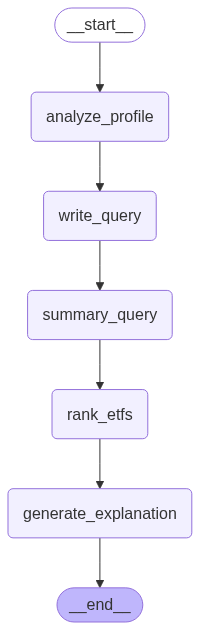

In [129]:
from langgraph.graph import START, StateGraph 
from IPython.display import Image, display

# 상태 그래프 생성
graph_builder = StateGraph(State)

graph_builder.add_sequence(
    [analyze_profile, write_query, summary_query, rank_etfs, generate_explanation]
)

graph_builder.add_edge(START, "analyze_profile")
graph = graph_builder.compile()

# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [132]:
question = """
은퇴를 앞두고 안정적인 수익을 기대할 수 있는 채권형 ETF를 찾고 있어요.
원금 손실 위험이 낮고, 장기적으로 꾸준히 운용할 수 있는 상품이면 좋겠습니다.
주식형 ETF보다는 변동성이 낮은 쪽을 선호합니다.
금리나 인플레이션 리스크를 어느 정도 커버할 수 있는지도 궁금해요.
제 투자 성향은 보수적인 편입니다.
"""

etf_recommendation = graph.invoke(
    {"question": question}
)
Markdown(etf_recommendation["final_answer"]["markdown"])

2025-06-29 22:00:25,002 - langfuse - ERROR - UUID('a9b08742-9e55-47aa-8b6f-3c068c282247')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('a9b08742-9e55-47aa-8b6f-3c068c282247')
2025-06-29 22:00:25,005 - langfuse - ERROR - UUID('1148b43c-1223-494a-a206-9ab5f8c521fe')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('1148b43c-1223-494a-a206-9ab5f8c521fe')
2025-06-29 22:00:25,009 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/pytho

🚀 LLM 호출 #165 시작 - 22:00:25
📝 프롬프트 길이: 551 문자


2025-06-29 22:00:26,411 - langfuse - ERROR - UUID('1148b43c-1223-494a-a206-9ab5f8c521fe')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('1148b43c-1223-494a-a206-9ab5f8c521fe')
2025-06-29 22:00:26,414 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:00:26,416 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 1.40초
🔢 토큰 사용량: {'completion_tokens': 49, 'prompt_tokens': 539, 'total_tokens': 588, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 207 문자


2025-06-29 22:00:55,583 - langfuse - ERROR - UUID('df70e219-3059-4638-88a6-64b13d75f1d8')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('df70e219-3059-4638-88a6-64b13d75f1d8')
2025-06-29 22:00:55,586 - langfuse - ERROR - UUID('fbf43779-f5ce-4804-8419-6b0464ea2097')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('fbf43779-f5ce-4804-8419-6b0464ea2097')
2025-06-29 22:00:55,587 - langfuse - ERROR - UUID('135751fa-dfe5-4f91-8da3-80c864103f8c')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/

🚀 LLM 호출 #166 시작 - 22:00:55
📝 프롬프트 길이: 3125 문자


2025-06-29 22:00:58,499 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:00:58,501 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:00:58,503 - langfuse - ERROR - UUID('135751fa-dfe5-4f91-8da3-80c864103f8c')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('135

✅ LLM 호출 완료 - 소요시간: 2.90초
📊 응답 길이: 0 문자
🚀 LLM 호출 #167 시작 - 22:00:58
📝 프롬프트 길이: 3200 문자


2025-06-29 22:01:00,437 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:00,441 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:00,443 - langfuse - ERROR - UUID('69d3c623-2cfd-424a-bbed-f89bb063a98f')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('69d

✅ LLM 호출 완료 - 소요시간: 1.92초
📊 응답 길이: 0 문자
🚀 LLM 호출 #168 시작 - 22:01:00
📝 프롬프트 길이: 5551 문자


2025-06-29 22:01:06,069 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:06,071 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:06,073 - langfuse - ERROR - UUID('59388a12-d952-4702-8b98-0082163dbf16')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('593

✅ LLM 호출 완료 - 소요시간: 5.60초
📊 응답 길이: 0 문자
🚀 LLM 호출 #169 시작 - 22:01:06
📝 프롬프트 길이: 705 문자


2025-06-29 22:01:11,245 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:11,247 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 501, in on_tool_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:11,249 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:11,251 - langfuse - ERROR - UUID('fbf43779-f5ce-4804-8419-6b

✅ LLM 호출 완료 - 소요시간: 5.16초
📊 응답 길이: 149 문자
🚀 LLM 호출 #170 시작 - 22:01:11
📝 프롬프트 길이: 6211 문자


2025-06-29 22:01:18,049 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:18,051 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:18,053 - langfuse - ERROR - UUID('1982fd89-01a5-4b12-9631-2306bb7950df')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('198

✅ LLM 호출 완료 - 소요시간: 6.79초
📊 응답 길이: 0 문자
🚀 LLM 호출 #171 시작 - 22:01:18
📝 프롬프트 길이: 7040 문자


2025-06-29 22:01:23,482 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:23,486 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:23,488 - langfuse - ERROR - UUID('7862b793-4a6a-4614-8124-b5ab12441909')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('786

✅ LLM 호출 완료 - 소요시간: 5.40초
📊 응답 길이: 0 문자
🚀 LLM 호출 #172 시작 - 22:01:23
📝 프롬프트 길이: 704 문자


2025-06-29 22:01:27,983 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:27,986 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 501, in on_tool_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:27,988 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:27,990 - langfuse - ERROR - UUID('fbf43779-f5ce-4804-8419-6b

✅ LLM 호출 완료 - 소요시간: 4.48초
📊 응답 길이: 162 문자
🚀 LLM 호출 #173 시작 - 22:01:28
📝 프롬프트 길이: 7712 문자


2025-06-29 22:01:33,821 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:33,824 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:33,825 - langfuse - ERROR - UUID('81a345ae-6455-45fd-9810-869b5b75df39')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('81a

✅ LLM 호출 완료 - 소요시간: 5.81초
📊 응답 길이: 815 문자
🚀 LLM 호출 #174 시작 - 22:01:33
📝 프롬프트 길이: 7458 문자


2025-06-29 22:01:41,754 - langfuse - ERROR - UUID('cc14240f-57e3-4c79-a3a2-c2f46587bc22')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('cc14240f-57e3-4c79-a3a2-c2f46587bc22')
2025-06-29 22:01:41,757 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:41,758 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 7.91초
🔢 토큰 사용량: {'completion_tokens': 519, 'prompt_tokens': 4001, 'total_tokens': 4520, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 1120 문자
🚀 LLM 호출 #175 시작 - 22:01:41
📝 프롬프트 길이: 1482 문자


2025-06-29 22:01:44,309 - langfuse - ERROR - UUID('d889b5ac-b2f5-4cf7-898f-1be9c7f7a7d1')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('d889b5ac-b2f5-4cf7-898f-1be9c7f7a7d1')
2025-06-29 22:01:44,312 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:44,312 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 2.54초
🔢 토큰 사용량: {'completion_tokens': 124, 'prompt_tokens': 811, 'total_tokens': 935, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 243 문자
🚀 LLM 호출 #176 시작 - 22:01:44
📝 프롬프트 길이: 1601 문자


2025-06-29 22:01:51,248 - langfuse - ERROR - UUID('3e5399e2-27f9-4e10-9ec7-a2a636ba7091')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('3e5399e2-27f9-4e10-9ec7-a2a636ba7091')
2025-06-29 22:01:51,250 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:01:51,251 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 6.92초
🔢 토큰 사용량: {'completion_tokens': 360, 'prompt_tokens': 770, 'total_tokens': 1130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 716 문자


# ETF 포트폴리오 추천

## 투자 전략 개요
본 포트폴리오는 보수적인 투자 성향과 은퇴 자금 마련이라는 목표에 맞춰, 변동성이 낮고 안정적인 수익을 추구하는 전략입니다. 주식은 제외하고, 신용등급이 높은 회사채에 집중하여 원금 손실 위험을 최소화하고 장기적으로 꾸준한 이자 수익을 기대할 수 있습니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| 1Q 25-08 회사채(A+이상)액티브 | 466400 | 100% |

## ETF 상세 설명

### 1Q 25-08 회사채(A+이상)액티브 (466400)
이 ETF는 신용등급 A+ 이상인 우량 회사채에 투자하는 액티브 ETF로, 주식이 전혀 포함되지 않아 매우 안정적입니다. 단기 회사채 위주로 구성되어 금리 변동에 따른 위험도 낮은 편입니다.

**주요 투자 포인트:**

* 신용등급이 높은 회사채에만 투자하여 안정성 극대화
* 주식이 포함되지 않아 원금 손실 위험이 매우 낮음
* 장기적으로 꾸준한 이자 수익 기대 가능

**투자 위험:**

* 금리 인상 시 채권 가격 하락 가능성
* 기업 신용등급 하락 시 일부 채권 가치 하락 위험
* 물가 상승(인플레이션) 시 실질 수익률 저하 가능성

## 투자 시 고려사항

* 본 포트폴리오는 주식이 전혀 포함되지 않아 시장 상승 시 수익률이 제한될 수 있습니다.
* 금리 변동 및 신용 위험 등 채권 투자 특유의 리스크에 유의해야 합니다.
* 장기 투자 시에도 정기적으로 포트폴리오 점검이 필요합니다.


In [133]:
question = """
이번에 단기 수익을 목표로 ETF에 투자해보려 합니다.
평소보다 조금 공격적인 전략을 써보고 싶은데, 변동성 있는 상품도 괜찮습니다.
레버리지 ETF도 고려하고 있어요.
다만 너무 생소한 테마보다는 어느 정도 검증된 분야면 좋겠어요.
수익률 기준으로 최근 3~6개월 사이에 성과가 좋았던 ETF가 궁금합니다.
"""

etf_recommendation = graph.invoke(
    {"question": question}
)
Markdown(etf_recommendation["final_answer"]["markdown"])

2025-06-29 22:09:10,898 - langfuse - ERROR - UUID('aa364482-7afd-4b0e-a5f9-f513482063c8')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('aa364482-7afd-4b0e-a5f9-f513482063c8')
2025-06-29 22:09:10,901 - langfuse - ERROR - UUID('c7443b7a-732d-48fb-97eb-97ceae82b2c6')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('c7443b7a-732d-48fb-97eb-97ceae82b2c6')
2025-06-29 22:09:10,904 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/pytho

🚀 LLM 호출 #177 시작 - 22:09:10
📝 프롬프트 길이: 549 문자


2025-06-29 22:09:14,766 - langfuse - ERROR - UUID('c7443b7a-732d-48fb-97eb-97ceae82b2c6')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('c7443b7a-732d-48fb-97eb-97ceae82b2c6')
2025-06-29 22:09:14,769 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:14,770 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 3.86초
🔢 토큰 사용량: {'completion_tokens': 43, 'prompt_tokens': 535, 'total_tokens': 578, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 193 문자


2025-06-29 22:09:43,528 - langfuse - ERROR - UUID('4133df2b-26ed-4bf9-8a4f-85fee387ef17')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('4133df2b-26ed-4bf9-8a4f-85fee387ef17')
2025-06-29 22:09:43,530 - langfuse - ERROR - UUID('312df694-bdbc-466a-84ce-687745551852')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('312df694-bdbc-466a-84ce-687745551852')
2025-06-29 22:09:43,531 - langfuse - ERROR - UUID('1dc94afa-3971-41e6-b7e1-f5adc16ab425')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/

🚀 LLM 호출 #178 시작 - 22:09:43
📝 프롬프트 길이: 3283 문자


2025-06-29 22:09:46,667 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:46,669 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:46,671 - langfuse - ERROR - UUID('1dc94afa-3971-41e6-b7e1-f5adc16ab425')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('1dc

✅ LLM 호출 완료 - 소요시간: 3.13초
📊 응답 길이: 0 문자
🚀 LLM 호출 #179 시작 - 22:09:46
📝 프롬프트 길이: 3374 문자


2025-06-29 22:09:49,539 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:49,543 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:49,545 - langfuse - ERROR - UUID('bf05f121-0fdc-44d9-a49f-41fde5e828b3')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('bf0

✅ LLM 호출 완료 - 소요시간: 2.85초
📊 응답 길이: 0 문자
🚀 LLM 호출 #180 시작 - 22:09:49
📝 프롬프트 길이: 5725 문자


2025-06-29 22:09:58,822 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:58,823 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:09:58,824 - langfuse - ERROR - UUID('7e4d04ee-5975-489c-8713-70d61d1feb12')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('7e4

✅ LLM 호출 완료 - 소요시간: 9.25초
📊 응답 길이: 0 문자
🚀 LLM 호출 #181 시작 - 22:09:58
📝 프롬프트 길이: 900 문자


2025-06-29 22:10:05,936 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:05,940 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 501, in on_tool_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:05,942 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:05,943 - langfuse - ERROR - UUID('312df694-bdbc-466a-84ce-68

✅ LLM 호출 완료 - 소요시간: 7.11초
📊 응답 길이: 344 문자
🚀 LLM 호출 #182 시작 - 22:10:05
📝 프롬프트 길이: 7163 문자


2025-06-29 22:10:16,889 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:16,892 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:16,893 - langfuse - ERROR - UUID('b5da9c54-96ee-4232-9b33-0358e1a4937b')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('b5d

✅ LLM 호출 완료 - 소요시간: 10.94초
📊 응답 길이: 0 문자
🚀 LLM 호출 #183 시작 - 22:10:16
📝 프롬프트 길이: 8861 문자


2025-06-29 22:10:24,112 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:24,116 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:24,117 - langfuse - ERROR - UUID('0b35fd26-e941-47e9-a4ac-e4ae108285a5')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('0b3

✅ LLM 호출 완료 - 소요시간: 7.19초
📊 응답 길이: 1470 문자
🚀 LLM 호출 #184 시작 - 22:10:24
📝 프롬프트 길이: 9262 문자


2025-06-29 22:10:38,014 - langfuse - ERROR - UUID('cccf41ec-0c53-4bac-9db3-bb841b33bc39')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('cccf41ec-0c53-4bac-9db3-bb841b33bc39')
2025-06-29 22:10:38,016 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:38,017 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 13.88초
🔢 토큰 사용량: {'completion_tokens': 776, 'prompt_tokens': 4600, 'total_tokens': 5376, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 1634 문자
🚀 LLM 호출 #185 시작 - 22:10:38
📝 프롬프트 길이: 1797 문자


2025-06-29 22:10:47,925 - langfuse - ERROR - UUID('1c9a9eb2-e625-420e-a34e-b00069f09783')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('1c9a9eb2-e625-420e-a34e-b00069f09783')
2025-06-29 22:10:47,927 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:10:47,928 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 9.90초
🔢 토큰 사용량: {'completion_tokens': 498, 'prompt_tokens': 940, 'total_tokens': 1438, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 1011 문자
🚀 LLM 호출 #186 시작 - 22:10:47
📝 프롬프트 길이: 2394 문자


2025-06-29 22:11:06,581 - langfuse - ERROR - UUID('a3c2eddc-59e5-43ad-a7e4-32c052155d40')
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 182, in on_chain_start
    LangfuseSpan, self.runs[parent_run_id]
                  ~~~~~~~~~^^^^^^^^^^^^^^^
KeyError: UUID('a3c2eddc-59e5-43ad-a7e4-32c052155d40')
2025-06-29 22:11:06,587 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run not found")
Exception: run not found
2025-06-29 22:11:06,588 - langfuse - ERROR - run not found
Traceback (most recent call last):
  File "/Users/sunhwaryu/Documents/llm-study/prj02/.venv/lib/python3.12/site-packages/langfuse/langchain/CallbackHandler.py", line 285, in on_chain_end
    raise Exception("run n

✅ LLM 호출 완료 - 소요시간: 18.62초
🔢 토큰 사용량: {'completion_tokens': 687, 'prompt_tokens': 1173, 'total_tokens': 1860, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}
📊 응답 길이: 1379 문자


# ETF 포트폴리오 추천

## 투자 전략 개요
고객님은 공격적인 투자 성향과 단기 자본 성장 목표를 가지고 있으나, 투자 경험이 초보 단계입니다. 이에 따라 높은 수익률을 추구할 수 있는 레버리지 ETF를 중심으로 포트폴리오를 구성하되, 변동성 및 위험 관리에 유의해야 합니다. 초보 투자자임을 감안해 ETF 수를 2~3개로 제한하고, 분산 효과를 일부 반영하였습니다.

## 추천 ETF 포트폴리오

| ETF | 종목코드 | 추천비중 |
|-----|----------|----------|
| ACE 미국빅테크TOP7 Plus레버리지(합성) | 465610 | 50% |
| PLUS 미국테크TOP10레버리지(합성) | 461910 | 30% |
| TIGER 미국나스닥100레버리지(합성) | 418660 | 20% |

## ETF 상세 설명

### ACE 미국빅테크TOP7 Plus레버리지(합성) (465610)
미국의 대표 빅테크 7개 기업에 2배 레버리지로 투자하는 ETF로, 단기적으로 높은 수익률을 추구하는 전략에 적합합니다.

**주요 투자 포인트:**

* 최근 1년간 매우 높은 수익률(207.87%) 기록
* 미국 빅테크 기업 집중 투자로 성장성 기대
* 레버리지 구조로 단기 수익 극대화 가능

**투자 위험:**

* 레버리지 특성상 변동성이 매우 큼
* 단기 급락 시 원금 손실 위험이 큼
* 초보 투자자에게는 진입 및 청산 타이밍이 어려울 수 있음

### PLUS 미국테크TOP10레버리지(합성) (461910)
미국 상위 10개 테크 기업에 2배 레버리지로 투자하는 ETF로, 기술주 중심의 단기 성장에 초점을 둡니다.

**주요 투자 포인트:**

* 1년 수익률 179.94%로 우수
* 미국 대표 테크 기업에 집중 투자
* 단기 자본 성장에 최적화

**투자 위험:**

* 레버리지 구조로 인한 높은 변동성
* 기술주 집중에 따른 섹터 리스크
* 단기 조정 시 손실 확대 가능

### TIGER 미국나스닥100레버리지(합성) (418660)
미국 나스닥100 지수를 2배 레버리지로 추종하는 ETF로, 다양한 성장주에 분산 투자하면서도 높은 수익을 노릴 수 있습니다.

**주요 투자 포인트:**

* 나스닥100 지수 기반으로 분산 효과 일부 기대
* 1년 수익률 106.09%로 우수
* 미국 성장주 전반에 투자

**투자 위험:**

* 레버리지 구조로 인한 변동성 확대
* 지수 급락 시 손실 위험
* 초보 투자자에게는 변동성 관리가 어려울 수 있음

## 투자 시 고려사항

* 레버리지 ETF는 단기 투자에 적합하며, 장기 보유 시 수익률이 왜곡될 수 있습니다.
* 초보 투자자는 손실 확대 가능성에 유의해야 하며, 투자 전 충분한 학습이 필요합니다.
* 시장 급락 시 원금 손실이 클 수 있으므로, 투자 금액을 신중히 결정하시기 바랍니다.
* 포트폴리오 내 ETF 수를 제한하여 관리의 복잡성을 줄였습니다.


---

## 10. 최종 구현 내용 및 결과

### 할루시네이션 감소
* 종목코드를 반드시 포함하도록 쿼리 생성을 유도하자, 응답의 정확성이 크게 향상됨
* 사용자 프로필 분석의 정확도를 높이고, ETS 상품 추천 시 부정확한 정보는 비워두도록 설계하여 할루시네이션 발생이 감소함
* 추천 기준을 보수적으로 적용해 필터링된 결과만 제공하도록 설계했으며, 이로 인해 추천 상품 수는 줄어들지만 정확도와 신뢰도는 향상됨

### 검색기 강화
* 고유명사 기반 검색 정확도 향상을 위해 종목명(영문명 포함), 운용사, 분류체계, 지정참가회사, 기본정보, 투자유의사항을 벡터화함
* 시맨틱 검색과 키워드 검색을 앙상블 방식으로 결합하여 검색 정밀도를 고도화함
* 쿼리 생성 시 기본정보 및 투자유의사항을 반영하여, 투자 목적과 기간까지 고려할 수 있도록 시도함

### Test Set

```markdown
은퇴를 앞두고 안정적인 수익을 기대할 수 있는 채권형 ETF를 찾고 있어요.
원금 손실 위험이 낮고, 장기적으로 꾸준히 운용할 수 있는 상품이면 좋겠습니다.
주식형 ETF보다는 변동성이 낮은 쪽을 선호합니다.
금리나 인플레이션 리스크를 어느 정도 커버할 수 있는지도 궁금해요.
제 투자 성향은 보수적인 편입니다.
```

```markdown
최근 ESG나 탄소중립 이슈에 관심이 많아졌어요.
기후 변화 대응이나 친환경 기술에 투자하는 ETF가 있다면 소개해 주세요.
예를 들면 재생에너지, 전기차, 탄소배출권 관련 테마가 궁금합니다.
단기 수익보다는 장기적인 성장 가능성을 보고 싶습니다.
혹시 미국이나 글로벌 친환경 ETF 중 괜찮은 게 있나요?
```

```markdown
이번에 단기 수익을 목표로 ETF에 투자해보려 합니다.
평소보다 조금 공격적인 전략을 써보고 싶은데, 변동성 있는 상품도 괜찮습니다.
레버리지 ETF도 고려하고 있어요.
다만 너무 생소한 테마보다는 어느 정도 검증된 분야면 좋겠어요.
수익률 기준으로 최근 3~6개월 사이에 성과가 좋았던 ETF가 궁금합니다.
```

```markdown
S&P500 지수를 추종하는 ETF를 고려 중입니다.
여러 상품이 있는 걸로 아는데, 수수료가 낮은 걸 우선적으로 보고 있어요.
추종 방식이나 배당 방식(분배 vs 재투자)도 고려해야 할까요?
장기 투자할 계획이라 비용 구조가 중요합니다.
미국 ETF와 한국 상장 ETF 모두 추천받을 수 있으면 좋겠습니다.
```

```markdown
최근에 기술주 중심 ETF의 수익률이 다시 좋아졌다고 들었어요.
AI, 반도체, 클라우드 관련 종목이 많이 포함된 ETF를 찾고 싶습니다.
최근 1년간 수익률 기준으로 상위권에 있는 상품이 궁금해요.
위험은 감수하더라도 성장 가능성이 높은 쪽을 선호합니다.
가능하다면 미국, 한국, 기타 국가 ETF도 비교해 주세요.
```

[Hugging Face Spaces](https://huggingface.co/spaces/flowersuna/recsys_etfs)